<a href="https://colab.research.google.com/github/evillag/TEC_DL_II-2022/blob/main/TP1/TP1_IBVOEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from time import time
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Curso de Aprendizaje Automático
# Trabajo Practico 1: 

**Escuela de Ingeniería en Computación | Instituto Tecnológico de Costa Rica**

Realizado por:

*   Victoria Orozco
*   Ignacio Barquero
*   Esteban Villalobos

Fecha de entrega:

* 2 de Octubre de 2022

El presente proyecto introduce el algoritmo de contornos activos para la segmentación de imágenes, el cual implementa un enfoque de optimización voraz.

Tipo de entrega: 

* Digital, por medio de la plataforma TEC-digital.

Modo de trabajo

* Grupos de 2/3 personas.

## 1) (30 puntos) Optimización de funciones

Para las siguientes funciones:

$f_{1}\left(x,y\right)=xe^{\left(-x^{2}-y^{2}\right)}$


### 1.1) Grafique tal función, y distinga si las funciones son convexas o no, y los puntos mínimos y regiones o puntos silla.

Mínimo aproximado: -0.4289
Punto mínimo aproximado: (-0.707, -0.0)
Máximo aproximado: 0.4289
Punto máximo aproximado: (0.707, -0.0)


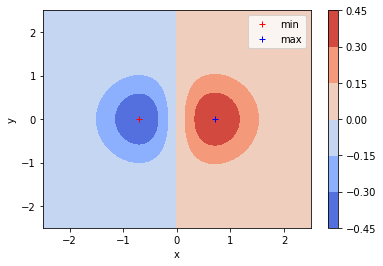

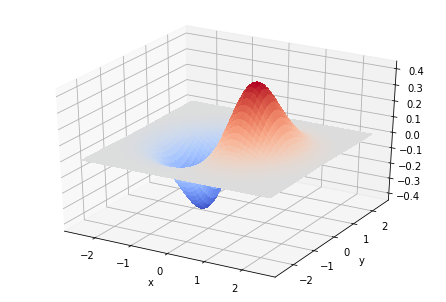

In [ ]:
%matplotlib inline
def f_1(x, y):
  return x * np.exp(-x**2-y**2)


def graph(min_x=-2.5, min_y=-2.5, max_x=2.5, max_y=2.5, interval=.001):
  x = np.arange(min_x, max_x, interval)
  y = np.arange(min_y, max_y, interval)
  X, Y = np.meshgrid(x, y)
  Z = f_1(X, Y)

  
  y_min_idx, x_min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
  y_max_idx, x_max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
 
  x_min = round(x[x_min_idx], 4)
  y_min = round(y[y_min_idx], 4)
  print(f"Mínimo aproximado: {round(Z[y_min_idx, x_min_idx], 4)}")  
  print(f"Punto mínimo aproximado: ({x_min}, {y_min})")  

  x_max = round(x[x_max_idx], 4)
  y_max = round(y[y_max_idx], 4)
  print(f"Máximo aproximado: {round(Z[y_max_idx, x_max_idx], 4)}")
  print(f"Punto máximo aproximado: ({x_max}, {y_max})")


  plt.figure()
  CS = plt.contourf(X, Y, Z, cmap=cm.coolwarm)
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.plot(x_min, y_min,'r+')
  plt.plot(x_max, y_max,'b+')
  plt.legend(['min', 'max'])
  plt.draw()
  
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
 
  plt.xlabel('x')
  plt.ylabel('y')
  plt.draw()
 

  return Z

Z = graph()

#### R/

¿La función es cóncava o convexa?
*   La función es cóncava cuando tanto $x$ como $y$ son positivos.
*   La función es convexa cuando tanto $x$ como $y$ son negativos.

¿Hay puntos silla?

* La función no presenta puntos silla.

¿Cuál es el mínimo del a función?

* El punto $(x, y)$ mínimo aproximado es $(-0.707, 0)$ 


¿Cuál es el máximo del a función?

* El punto $(x, y)$ máximo aproximado es $(0.707, 0)$ 



### 1.2) (10 puntos) Implemente el algoritmo del descenso del gradiente con moméntum:

**a)** Escoja un coeficiente de aprendizaje $\alpha$ que permita la convergencia y reporte los resultados para 10 corridas:

1. La tolerancia fijada para la convergencia en términos de la magnitud del gradiente, 

2. La cantidad de iteraciones necesarias para converger,

3. El punto de convergencia.

4. Escoga una de las corridas y en una gráfica muestre los puntos probados (visitados) por el algoritmo.



**b)** Escoja un $\alpha$ relativamente grande respecto al valor seleccionado ¿Qué sucede? ¿Permite un $\alpha$ muy grande la convergencia?


**c)** ¿Qué sucede si escoge un $\alpha$ muy pequeño? 


**d)** ¿Cómo puede el algoritmo de descenso de gradiente evitar quedar atrapado en mínimos locales o puntos silla?

### 1.3) (20 puntos) Implemente el algoritmo de Newton-Raphson:

**a)** Calcule la matriz Hessiana demostrando cada paso intermedio.

**b)** Reporte los resultados para 10 corridas:

1. La tolerancia fijada para la convergencia en términos de la magnitud del gradiente,

2. La cantidad de iteraciones necesarias para converger,

3. El punto de convergencia.

4. Escoga una de las corridas y en una gráfica muestre los puntos probados por el algoritmo.

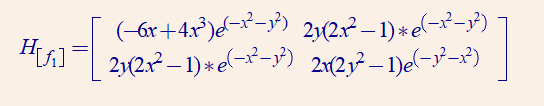

In [ ]:
def NumericHesianMatrix(x, y):
  value0_0 = (-6*x+4*x**3)*(math.e**(-x**2-y**2))
  value0_1 = 2*y*(2*x**2-1)*math.e**(-x**2-y**2)
  value1_0 = value0_1
  value1_1 = 2*x*(2*y**2-1)*math.e**(-y**2-x**2)
  return torch.tensor([[value0_0,value0_1],[value1_0,value1_1]])

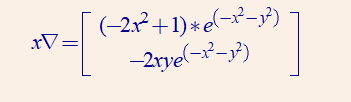

In [ ]:
def evaluateGradientVector(x,y):
  x1 = (-2*x**2+1)*math.e**(-x**2-y**2)
  x2 = -2*x*y*math.e**(-x**2-y**2)
  return torch.tensor([[x1],[x2]])

In [ ]:
def newtonRaphson():
  x_t = torch.randint(low=-50, high=50, size=(2,1)) 
  print("x0", x_t)
  cont = 1
  while(True):
    print("Iteración: ",cont)

    #Evaluar x_t en la matriz hessiana
    hessianMatrix = NumericHesianMatrix(x_t[0],x_t[1])
    #Invertir la matriz hessiana (pseudoinversa)
    hessianInverse = torch.linalg.pinv(hessianMatrix)
    print("Inversa hessiana: ", hessianInverse)

    #Evaluar x_t en el vector gradiente
    gradientEvaluation = evaluateGradientVector(x_t[0], x_t[1])
    print("Evaluación del vector gradiente x_t: ", gradientEvaluation)

    #Calcular delta X
    deltaX = torch.mm(-hessianInverse, gradientEvaluation)
    print("deltaX: ", deltaX)

    #Calcular X(t+1)
    X_t_1 = x_t + deltaX 
    print("X(t+1): ", X_t_1)
    x0 = X_t_1 
    cont+=1

    print("---------------------")
    if(cont==100):
      break

newtonRaphson()

x0 tensor([[13],
        [-6]])
Iteración:  1
Inversa hessiana:  tensor([[0., 0.],
        [0., 0.]])
Evaluación del vector gradiente x_t:  tensor([[-0.],
        [0.]])
deltaX:  tensor([[0.],
        [0.]])
X(t+1):  tensor([[13.],
        [-6.]])
---------------------
Iteración:  2
Inversa hessiana:  tensor([[0., 0.],
        [0., 0.]])
Evaluación del vector gradiente x_t:  tensor([[-0.],
        [0.]])
deltaX:  tensor([[0.],
        [0.]])
X(t+1):  tensor([[13.],
        [-6.]])
---------------------
Iteración:  3
Inversa hessiana:  tensor([[0., 0.],
        [0., 0.]])
Evaluación del vector gradiente x_t:  tensor([[-0.],
        [0.]])
deltaX:  tensor([[0.],
        [0.]])
X(t+1):  tensor([[13.],
        [-6.]])
---------------------
Iteración:  4
Inversa hessiana:  tensor([[0., 0.],
        [0., 0.]])
Evaluación del vector gradiente x_t:  tensor([[-0.],
        [0.]])
deltaX:  tensor([[0.],
        [0.]])
X(t+1):  tensor([[13.],
        [-6.]])
---------------------
Iteración:  5
In

### 1.4) Investigue y reporte las principales ventajas y desventajas, usando los resultados obtenidos, del algoritmo Newton Raphson respecto al algoritmo del descenso del gradiente con moméntum, citando adecuadamente las referencias.

#### R/ TODO

## 2) (30 puntos) Perceptrón multi-capa para detección de glaucoma en imágenes de fondo de ojo


En el presente problema, se construirá un perceptrón multi-capa para clasificar imágenes de fondo de ojo en normales o con presencia de glaucoma
como patología. El conjunto de datos a utilizar tiene por nombre ACRIMA, y
esta compuesto por 706 imágenes del disco óptico, el cual se puede utilizar
para detectar la presencia de glaucoma. La forma del disco optico cambia con
la presencia de glaucoma, con un mayor tamaño y una copa mayor como se
observa en la Figura 1.



Para resolver el problema de clasificación binaria, se construirá una red
neuronal.


1. Modifique el perceptrón multi-capa y la red convolucional implementadas en el codigo base provisto. Explique las modificaciones necesarias
para implementar que ambos modelos funcionen para el objetivo especificado.

  * a) Entrene el perceptrón multi-capa usando el conjunto de datos completo para entrenamiento y validación. Calibre los hiper-parámetros
necesarios para obtener los mejores resultados posibles y reportelos. Ejecute el entrenamiento $10$ veces por $15$ épocas por corrida, y
reporte la tasa de aciertos tasa de aciertos, falsos positivos y falsos
negativos promedio y su desviación estándar para esas 10 corridas.

  * No utilice ningún tipo de aumentado o normalización de datos.


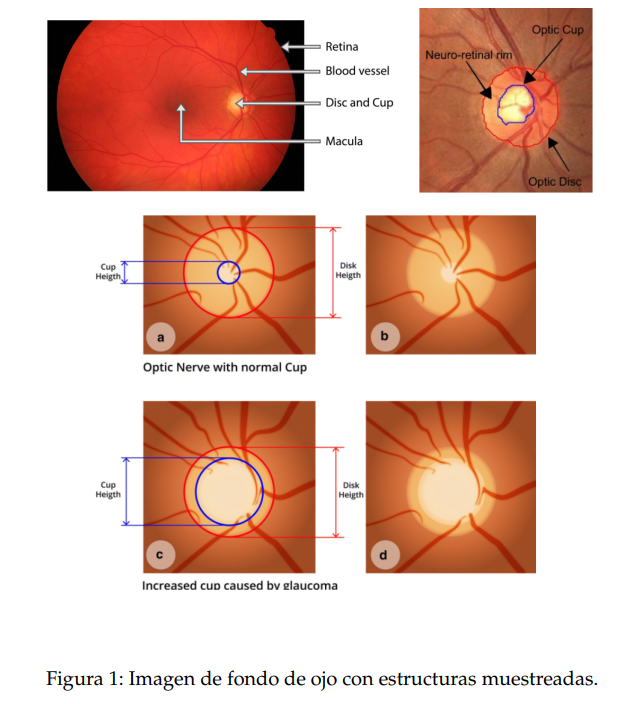

### a) Resultados

Los cambios realizados para poder utilizar el notebook provisto para utilizarlo con este conjunto de datos fueron los siguientes:

  * Las imágenes tienen diferentes dimensiones, que rondan los 350x350 a 550x500 pixeles aproximadamente, a color. Se tomó la decisión de reducir sus dimensiones a 128x128, manteniendo los 3 canales de color, por lo que cada imagen terminó teniendo $49152$ pixeles.

    > Se hicieron pruebas con resuluciones más altas y con los tres canales de color (R, G, B), sin embargo el ambiente de ejecución disponible se quedaba sin memoria después de algunos cuantos epochs.

  * No se realizó la normalización de las imágenes, como es solicitado en el ejercicio.

  * Para la carga de imágenes se definió utilzar batches de $1$, para evitar el problema de memoria del ambiente.

  * Se modificó el despliegue de las imagenes para considerar la forma correcta, pues ahora estan representadas en una matriz de 3 X 128 X 128.


  * Todos los modelos fueron creados con valores de pesos aleatorios asignados por pytorch, donde la red neronal tenia las siguientes caracteristicas:

    *   Tamaño de la capa de entrada: $49152$ neuronas (una por pixel), $12288$ de salida, usando $Sigmoid$ como función de activación.
    *   Capa oculta: una capa con $12288$ neuronas de entrada y $192$ de salida, usando Sigmoid como función de activación.
    * Capa de salida: $192$ neuronas de entrada, y $2$ de salida (una para cada clase), aplicando la función de activación $LogSoftmax$, para obtener la probabilidad de que la observación pertenezca a cada clase.
    * Se utilizó un optimizador de Descenso de Gradiente estocástico con momentum de $0.9$.
    * Después de multiples pruebas preliminares, se determinó que el mejor coeficiente de aprendizaje $α$ fue el de $0.001$.
  
  * Se agregaron contadores la función `test_model_mlp` para contar los falos positivos y falsos negativos.

  * Se creó la función `train_models` para realizar las 10 corridas con modelos inicializados con pesos aleatorios y obtener los resultados.


------------


**Resultado del entrenamiento**


El entrenamiento de los $10$ modelos consistió en $15$ epochs, dando los siguientes resultados (FP = Falsos positivos, FN = Falsos negativos):

Corrida | Accuracy | FP | FN
--------|----------|----|---
0 | 0.83809 | 29   | 5
1 | 0.63809 | 76   | 0
2 | 0.88095 | 17   | 8
3 | 0.82857 | 34   | 2
4 | 0.70952 | 61   | 0
5 | 0.72381 | 58   | 0
6 | 0.85238 | 26   | 5
7 | 0.82381 | 34   | 3
8 | 0.70952 | 60   | 1
9 | 0.9     | 10   | 11

Con las siguientes estadísticas:

Métrica |Promedio | Desv. Estándar
--|--|--
Accuracy | 0.79048 | 0.08343
FP       | 40.5    | 20.679700
FN       | 3.5     | 3.55668


El mejor accuracy alcanzado fue de $0.9$ en la última corrida del algoritmo:

```
Training MLP model #9
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7048563933432704
Epoch 1 - Training loss: 0.6799624564671757
Epoch 2 - Training loss: 0.6773081389942555
Epoch 3 - Training loss: 0.6742508130242126
Epoch 4 - Training loss: 0.6650206307871173
Epoch 5 - Training loss: 0.644316765289716
Epoch 6 - Training loss: 0.5406769354536076
Epoch 7 - Training loss: 0.4401897156780416
Epoch 8 - Training loss: 0.4089464833734162
Epoch 9 - Training loss: 0.3905218470121988
Epoch 10 - Training loss: 0.3655518426122426
Epoch 11 - Training loss: 0.3692200284121991
Epoch 12 - Training loss: 0.34196784223025345
Epoch 13 - Training loss: 0.33406391855131723
Epoch 14 - Training loss: 0.3241130915658567

Training Time (in minutes) = 5.763623468081156
Testing MLP model #9
Number Of Images Tested = 210

Model Accuracy = 0.9

True positives = 94

True Negatives = 95

False positives = 10

False Negatives = 11
------------------------------------------------------
Best Model and Accuracy: Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
0.9
```


### b) Código fuente

#### Descarga y extracción del dataset

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/evillag/TEC_DL_II-2022/main/TP1/dataset_train_test.zip
!unzip dataset_train_test.zip
#cleanup
!rm -f dataset_train_test.zip 

#### Estandarización de los datos

In [ ]:
_IMAGE_SIZE = [128, 128]

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize(_IMAGE_SIZE),
    #transforms.Grayscale(num_output_channels=1),    
])

#### Carga de datos

torch.Size([1, 3, 128, 128])
torch.Size([1])


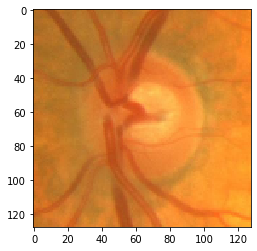

In [ ]:
_TRAIN_PATH = 'dataset_train_test/train'
_TEST_PATH = 'dataset_train_test/test'
_BATCH_SIZE = 1

def load_test_train_data(train_path = _TRAIN_PATH, test_path = _TEST_PATH, 
                         bach_size=64):
    train_set = datasets.ImageFolder(root= train_path, transform = transform)    
    test_set = datasets.ImageFolder(root= test_path, transform = transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bach_size,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bach_size,
                                              shuffle=True)
    return train_loader, test_loader

train_loader, test_loader = load_test_train_data(bach_size=_BATCH_SIZE)
dataiter = iter(train_loader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9) 

print(images.shape)
print(labels.shape)

# grayscale
# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# In order to plot a color image with RGB (3) channels, we need to transform the 
# dimensions for imshow from [3 x 128 x 128] to [128 x 128 x 3]:
im2display = images[0].numpy().transpose((1,2,0))
plt.imshow(im2display, interpolation='nearest');

#### Función para crear el modelo de perceptrón multicapa

In [ ]:
_COLOR_CHANNELS = 3
_INPUT_LAYER = _IMAGE_SIZE[0] * _IMAGE_SIZE[1]  * _COLOR_CHANNELS  # pixels
_HIDDEN_LAYER_0 = _INPUT_LAYER // 4
_HIDDEN_LAYER_1 = _HIDDEN_LAYER_0 // 64
_OUTPUT_LAYER = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_MLP_model():
    # Model creation with neural net Sequential model
    model=nn.Sequential(
        nn.Linear(_INPUT_LAYER, _HIDDEN_LAYER_0),   # 1 layer: _INPUT_LAYER features (pixels)
        #nn.ReLU(),                                  # Defining Regular linear unit as activation
        nn.Sigmoid(),
        
        nn.Linear(_HIDDEN_LAYER_0, _HIDDEN_LAYER_1),  # 2 Layer: 1/2 size prev layer
        #nn.Tanh(),                                  # Defining Regular linear unit as activation
        nn.Sigmoid(),
        #nn.ReLU(),
        
        nn.Linear(_HIDDEN_LAYER_1, _OUTPUT_LAYER),   # Out Layer
        nn.LogSoftmax(dim=1) # Defining the log softmax to find the probablities for the last output unit
    ) 
    return model


def get_new_model(seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  print("Running on device: ", device)
  mlp_model = create_MLP_model()

  #moving models to device
  mlp_model.to(device)
  #create error criterion
  criterion = nn.NLLLoss() 
  print("MLP model\n", mlp_model)

  return mlp_model, criterion


# _model, _criterion = get_new_model()

#### Función de entrenamiento

In [ ]:
def train_model(model, criterion, trainloader, epochs = 15, lr = 0.01):
    time0 = time()    
    running_loss_list= []
    epochs_list = []
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for e in range(epochs):
        running_loss = 0
        
        #go for every batch
        for images, labels in trainloader:          
            #move data to specific device            
            images = images.to(device)
            labels = labels.to(device)

            # Flatenning MNIST images with size [64,784] (for MLP)
            images = images.view(images.shape[0], -1) # hace un flattening de las imagenes para que sean un vector

            # defining gradient in each epoch as 0
            optimizer.zero_grad()
            # modeling for each image batch
            output = model(images)
            
            # calculating the loss            
            loss = criterion(output, labels)  # tener cuidado que tanto etiquetas como outputs esten en el formato que espera la func de error
    
            # This is where the model learns by backpropagating
            loss.backward()  # Calculo de los gradientes (Matrioshka mas grande).

            # And optimizes its weights here
            optimizer.step()  # Actualiza pesos en todas las capas

            # calculating the loss
            running_loss += loss.item()
            # print(f'Output {output}, labels {labels}, loss {loss.item()}')

        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    return model


#### Función de validación del modelo

In [ ]:
def test_model_mlp(testloader, model):
    tp, tn, fp, fn, correct_count, all_count = 0, 0, 0, 0, 0, 0
    for images,labels in testloader:
      #move data to specific device
      images = images.to(device)
      labels = labels.to(device)
      for i in range(len(labels)):
        img = images[i].view(1, _INPUT_LAYER)
        #evaluate model with no grad
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        #get predicted label
        pred_label = probab.index(max(probab))
        true_label = labels.cpu().numpy()[i]        
        
        if true_label == pred_label:
          correct_count += 1
          if true_label:
            tp += 1
          else: 
            tn += 1

        elif pred_label == 1: # 1 -> glaucoma
          fp += 1 
        else:
          fn += 1

        all_count += 1

    accuracy = correct_count/all_count
    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", accuracy)
    print("\nTrue positives =", tp)
    print("\nTrue Negatives =", tn)
    print("\nFalse positives =", fp)
    print("\nFalse Negatives =", fn)
    return accuracy, all_count, tp, tn, fp, fn


#### Entrenamiento y Validación

In [ ]:
def train_models():
  accuracies = []
  fps = []
  fns = []
  tps = []
  tns = []  
  best_accuracy = 0.0
  best_model = None  
  alpha = 0.001
  
  for run in range(10):
    print(f"Training MLP model #{run}")
    new_model, criterion = get_new_model()
    mlp_model = train_model(new_model, criterion, train_loader, epochs = 15, 
                            lr = alpha)
    print(f"Testing MLP model #{run}")
    accuracy, all_count, tp, tn, fp, fn = test_model_mlp(test_loader, mlp_model)
    accuracies.append(accuracy)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    tns.append(tn)
    if accuracy > best_accuracy:
      best_accuracy = accuracy  
      best_model = mlp_model
      
    torch.cuda.empty_cache()
    print("------------------------------------------------------")
  
  return best_model, best_accuracy, accuracies, fps, fns, tps, tns

mlp_model, mlp_accuracy, accuracies, fps, fns, tps, tns = train_models()
print(f"Best Model and Accuracy: {mlp_model}\n{mlp_accuracy}")


Training MLP model #0
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7081129658327561
Epoch 1 - Training loss: 0.6744557219322281
Epoch 2 - Training loss: 0.6706535677115123
Epoch 3 - Training loss: 0.654503731053285
Epoch 4 - Training loss: 0.6002920478281348
Epoch 5 - Training loss: 0.47557623297578155
Epoch 6 - Training loss: 0.4564351361418952
Epoch 7 - Training loss: 0.4283097395546396
Epoch 8 - Training loss: 0.36238794559236576
Epoch 9 - Training loss: 0.3516975526871969
Epoch 10 - Training loss: 0.3571398511961705
Epoch 11 - Training loss: 0.32551355839946844
Epoch 12 - Training loss: 0.32518771284382153
Epoch 13 - Training loss: 0.3328106673190963
Epoch 14 - Training loss: 0.32435682961068146

Training Time (

Respaldo de resulado de 10 corridas:

```
Training MLP model #0
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7081129658327561
Epoch 1 - Training loss: 0.6744557219322281
Epoch 2 - Training loss: 0.6706535677115123
Epoch 3 - Training loss: 0.654503731053285
Epoch 4 - Training loss: 0.6002920478281348
Epoch 5 - Training loss: 0.47557623297578155
Epoch 6 - Training loss: 0.4564351361418952
Epoch 7 - Training loss: 0.4283097395546396
Epoch 8 - Training loss: 0.36238794559236576
Epoch 9 - Training loss: 0.3516975526871969
Epoch 10 - Training loss: 0.3571398511961705
Epoch 11 - Training loss: 0.32551355839946844
Epoch 12 - Training loss: 0.32518771284382153
Epoch 13 - Training loss: 0.3328106673190963
Epoch 14 - Training loss: 0.32435682961068146

Training Time (in minutes) = 5.193756453196207
Testing MLP model #0
Number Of Images Tested = 210

Model Accuracy = 0.8380952380952381

True positives = 100

True Negatives = 76

False positives = 29

False Negatives = 5
------------------------------------------------------
Training MLP model #1
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.716302223578848
Epoch 1 - Training loss: 0.6790270113583767
Epoch 2 - Training loss: 0.6766520433353655
Epoch 3 - Training loss: 0.6648387010651405
Epoch 4 - Training loss: 0.631251274756711
Epoch 5 - Training loss: 0.5154247618684865
Epoch 6 - Training loss: 0.4619043334613018
Epoch 7 - Training loss: 0.3961131728611736
Epoch 8 - Training loss: 0.39002389807743254
Epoch 9 - Training loss: 0.37121405449009154
Epoch 10 - Training loss: 0.3306641107114653
Epoch 11 - Training loss: 0.3202359981293969
Epoch 12 - Training loss: 0.3307526993087841
Epoch 13 - Training loss: 0.2987889055901141
Epoch 14 - Training loss: 0.3021641301995407

Training Time (in minutes) = 5.282465406258901
Testing MLP model #1
Number Of Images Tested = 210

Model Accuracy = 0.638095238095238

True positives = 105

True Negatives = 29

False positives = 76

False Negatives = 0
------------------------------------------------------
Training MLP model #2
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7014944792245373
Epoch 1 - Training loss: 0.6755898632184424
Epoch 2 - Training loss: 0.6700330698128902
Epoch 3 - Training loss: 0.6418402552604675
Epoch 4 - Training loss: 0.5577939969496896
Epoch 5 - Training loss: 0.44909460306675597
Epoch 6 - Training loss: 0.4361652084454574
Epoch 7 - Training loss: 0.40953245540102473
Epoch 8 - Training loss: 0.37359196854204957
Epoch 9 - Training loss: 0.34689054103530564
Epoch 10 - Training loss: 0.3297648633461013
Epoch 11 - Training loss: 0.3192999166055498
Epoch 12 - Training loss: 0.30764127340158354
Epoch 13 - Training loss: 0.30919233625754716
Epoch 14 - Training loss: 0.3022182516906542

Training Time (in minutes) = 5.299810636043548
Testing MLP model #2
Number Of Images Tested = 210

Model Accuracy = 0.8809523809523809

True positives = 97

True Negatives = 88

False positives = 17

False Negatives = 8
------------------------------------------------------
Training MLP model #3
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7010703601620414
Epoch 1 - Training loss: 0.6775747038499274
Epoch 2 - Training loss: 0.6617800813130658
Epoch 3 - Training loss: 0.6142861088869548
Epoch 4 - Training loss: 0.4996556828663957
Epoch 5 - Training loss: 0.4402991150355324
Epoch 6 - Training loss: 0.4229138726227437
Epoch 7 - Training loss: 0.3930761086608688
Epoch 8 - Training loss: 0.3723652276556205
Epoch 9 - Training loss: 0.34268846481737464
Epoch 10 - Training loss: 0.3217746701989925
Epoch 11 - Training loss: 0.3209453383154904
Epoch 12 - Training loss: 0.3139570545722646
Epoch 13 - Training loss: 0.2986699614845536
Epoch 14 - Training loss: 0.2826947783410427

Training Time (in minutes) = 5.324053227901459
Testing MLP model #3
Number Of Images Tested = 210

Model Accuracy = 0.8285714285714286

True positives = 103

True Negatives = 71

False positives = 34

False Negatives = 2
------------------------------------------------------
Training MLP model #4
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7053931501929206
Epoch 1 - Training loss: 0.6777424146430661
Epoch 2 - Training loss: 0.6728733544397836
Epoch 3 - Training loss: 0.6575471573706829
Epoch 4 - Training loss: 0.5888527660771753
Epoch 5 - Training loss: 0.48486173112284053
Epoch 6 - Training loss: 0.44590257336714806
Epoch 7 - Training loss: 0.4269030918889312
Epoch 8 - Training loss: 0.37032339227470484
Epoch 9 - Training loss: 0.35000888914871736
Epoch 10 - Training loss: 0.33391626980814215
Epoch 11 - Training loss: 0.3147503283665036
Epoch 12 - Training loss: 0.32436064230019435
Epoch 13 - Training loss: 0.30806172314520947
Epoch 14 - Training loss: 0.29016229128065246

Training Time (in minutes) = 5.32544854482015
Testing MLP model #4
Number Of Images Tested = 210

Model Accuracy = 0.7095238095238096

True positives = 105

True Negatives = 44

False positives = 61

False Negatives = 0
------------------------------------------------------
Training MLP model #5
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7042609257830514
Epoch 1 - Training loss: 0.6790579745865831
Epoch 2 - Training loss: 0.6729916709240037
Epoch 3 - Training loss: 0.646722311895303
Epoch 4 - Training loss: 0.591799604132621
Epoch 5 - Training loss: 0.4857037363818499
Epoch 6 - Training loss: 0.4314344868948213
Epoch 7 - Training loss: 0.3733822638761591
Epoch 8 - Training loss: 0.3892499462663751
Epoch 9 - Training loss: 0.36770294751463967
Epoch 10 - Training loss: 0.35955588971123553
Epoch 11 - Training loss: 0.33632021174022947
Epoch 12 - Training loss: 0.31964814211994486
Epoch 13 - Training loss: 0.30427393726898694
Epoch 14 - Training loss: 0.30838955334044355

Training Time (in minutes) = 5.3756426811218265
Testing MLP model #5
Number Of Images Tested = 210

Model Accuracy = 0.7238095238095238

True positives = 105

True Negatives = 47

False positives = 58

False Negatives = 0
------------------------------------------------------
Training MLP model #6
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7148824906108355
Epoch 1 - Training loss: 0.6795202500892408
Epoch 2 - Training loss: 0.6773251453433374
Epoch 3 - Training loss: 0.671960568127006
Epoch 4 - Training loss: 0.6516618056730791
Epoch 5 - Training loss: 0.5755848644508256
Epoch 6 - Training loss: 0.48470767828626465
Epoch 7 - Training loss: 0.4661348598590591
Epoch 8 - Training loss: 0.40407311871102214
Epoch 9 - Training loss: 0.3687288566290241
Epoch 10 - Training loss: 0.36244436552644604
Epoch 11 - Training loss: 0.3306065918666057
Epoch 12 - Training loss: 0.3153523925705954
Epoch 13 - Training loss: 0.3307006806034049
Epoch 14 - Training loss: 0.28980912496241734

Training Time (in minutes) = 5.5296404202779135
Testing MLP model #6
Number Of Images Tested = 210

Model Accuracy = 0.8523809523809524

True positives = 100

True Negatives = 79

False positives = 26

False Negatives = 5
------------------------------------------------------
Training MLP model #7
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7153148327813004
Epoch 1 - Training loss: 0.6802282038963202
Epoch 2 - Training loss: 0.6714640869034662
Epoch 3 - Training loss: 0.6700507790753336
Epoch 4 - Training loss: 0.6531652342339959
Epoch 5 - Training loss: 0.5500995048669853
Epoch 6 - Training loss: 0.49873326403662716
Epoch 7 - Training loss: 0.41162889907559885
Epoch 8 - Training loss: 0.36396975248506425
Epoch 9 - Training loss: 0.39048077953777116
Epoch 10 - Training loss: 0.34087114341303026
Epoch 11 - Training loss: 0.3366776958324316
Epoch 12 - Training loss: 0.3166414540418602
Epoch 13 - Training loss: 0.33457318569881594
Epoch 14 - Training loss: 0.2999193473092299

Training Time (in minutes) = 5.56394628683726
Testing MLP model #7
Number Of Images Tested = 210

Model Accuracy = 0.8238095238095238

True positives = 102

True Negatives = 71

False positives = 34

False Negatives = 3
------------------------------------------------------
Training MLP model #8
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7125893415525706
Epoch 1 - Training loss: 0.6816455508723404
Epoch 2 - Training loss: 0.6702041144623901
Epoch 3 - Training loss: 0.6730233358614373
Epoch 4 - Training loss: 0.6450984061968447
Epoch 5 - Training loss: 0.5967002296538064
Epoch 6 - Training loss: 0.4803223241496869
Epoch 7 - Training loss: 0.45649333292373806
Epoch 8 - Training loss: 0.38574933532738326
Epoch 9 - Training loss: 0.3928695217511062
Epoch 10 - Training loss: 0.3329042904939728
Epoch 11 - Training loss: 0.3399143910922129
Epoch 12 - Training loss: 0.3425494200479465
Epoch 13 - Training loss: 0.32515899988662716
Epoch 14 - Training loss: 0.2895145462696544

Training Time (in minutes) = 5.495431824525197
Testing MLP model #8
Number Of Images Tested = 210

Model Accuracy = 0.7095238095238096

True positives = 104

True Negatives = 45

False positives = 60

False Negatives = 1
------------------------------------------------------
Training MLP model #9
Running on device:  cuda
MLP model
 Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.7048563933432704
Epoch 1 - Training loss: 0.6799624564671757
Epoch 2 - Training loss: 0.6773081389942555
Epoch 3 - Training loss: 0.6742508130242126
Epoch 4 - Training loss: 0.6650206307871173
Epoch 5 - Training loss: 0.644316765289716
Epoch 6 - Training loss: 0.5406769354536076
Epoch 7 - Training loss: 0.4401897156780416
Epoch 8 - Training loss: 0.4089464833734162
Epoch 9 - Training loss: 0.3905218470121988
Epoch 10 - Training loss: 0.3655518426122426
Epoch 11 - Training loss: 0.3692200284121991
Epoch 12 - Training loss: 0.34196784223025345
Epoch 13 - Training loss: 0.33406391855131723
Epoch 14 - Training loss: 0.3241130915658567

Training Time (in minutes) = 5.763623468081156
Testing MLP model #9
Number Of Images Tested = 210

Model Accuracy = 0.9

True positives = 94

True Negatives = 95

False positives = 10

False Negatives = 11
------------------------------------------------------
Best Model and Accuracy: Sequential(
  (0): Linear(in_features=49152, out_features=12288, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=12288, out_features=192, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=192, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)
0.9
```

## 3) (40 puntos) Redes convolucionales para detección de glaucoma en imágenes de fondo de ojo

### 1.(20 puntos) Implemente el filtro de «Unsharp masking» para la mejora de las imágenes, según lo especificado en el material del curso.
    

  * a)  Compruebe y comente su uso para las imágenes de fondo de ojo, mostrando los resultados. Use al menos dos valores distintos de la ganancia λ.
    

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys


def openImage(path):
    """Opens an image

      @param path, path to open image
      @return imageTensor, pytorch tensor matrix
    """
    
    #use cv2 to open image
    image = cv2.imread(path, 0) # 0 is grayscale
    #convert to pytorch tensor
    imageTensor = torch.FloatTensor(image)
    return imageTensor


def apply_unsharp_mask(inputPath, gains = [1.5, 3.0]):
    """Apply an Unsharp Masking to an image

    An image G with unsharp masking is defined by:

    G = U + lamda*B

    Where:

    U = Original image
    Lambda = Gain coefficient
    B = -E
    E ~ U - (U * GaussianMask)
    GaussianMask => Gaussian Blur filter
    """
    
    # read image
    U = openImage(inputPath)
    print("Image dimensions: ", U.size())

    # Apply a Gaussian Blur
    U_blurred = transforms.functional.gaussian_blur(U.unsqueeze(0), 
                                                    kernel_size=11).squeeze()    
    
    E = U - U_blurred
    B = E.mul(-1.0)
    G1 = U + B.mul(gains[0])
    G2 = U + B.mul(gains[1])

    ax=[]
    f = plt.figure(figsize=(24,5))    
    ax.append(f.add_subplot(131))
    ax.append(f.add_subplot(132))
    ax.append(f.add_subplot(133))    
    ax[0].imshow(U, cmap='gray')
    ax[0].set_title("Original")
    ax[1].imshow(G1, cmap='gray')
    ax[1].set_title(f"Gain = {gains[0]}")
    ax[2].imshow(G2, cmap='gray')
    ax[2].set_title(f"Gain = {gains[1]}")
    plt.show()


Image dimensions:  torch.Size([346, 346])


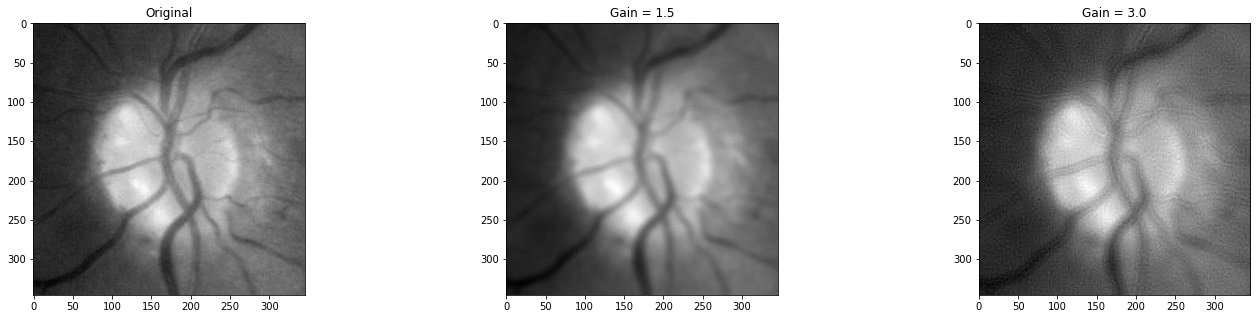

In [ ]:
apply_unsharp_mask("dataset_train_test/train/0/Im106_ACRIMA.jpg")

Image dimensions:  torch.Size([346, 346])


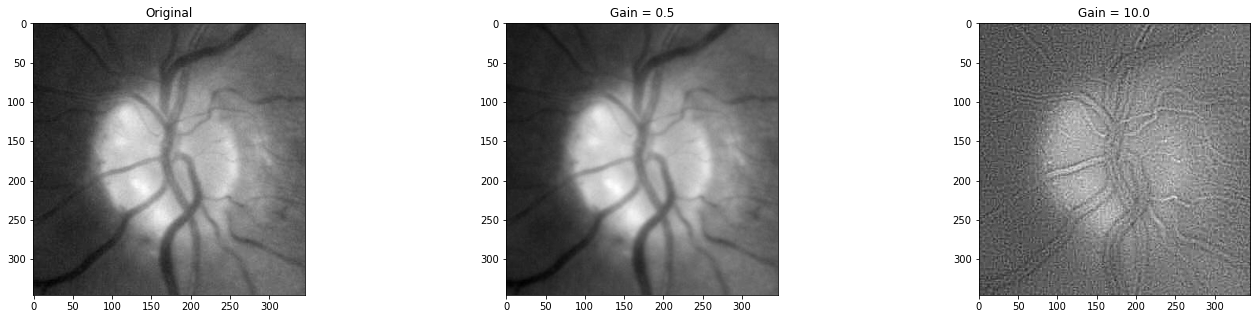

In [ ]:
apply_unsharp_mask("dataset_train_test/train/0/Im106_ACRIMA.jpg", [0.5, 10.0])

Image dimensions:  torch.Size([409, 409])


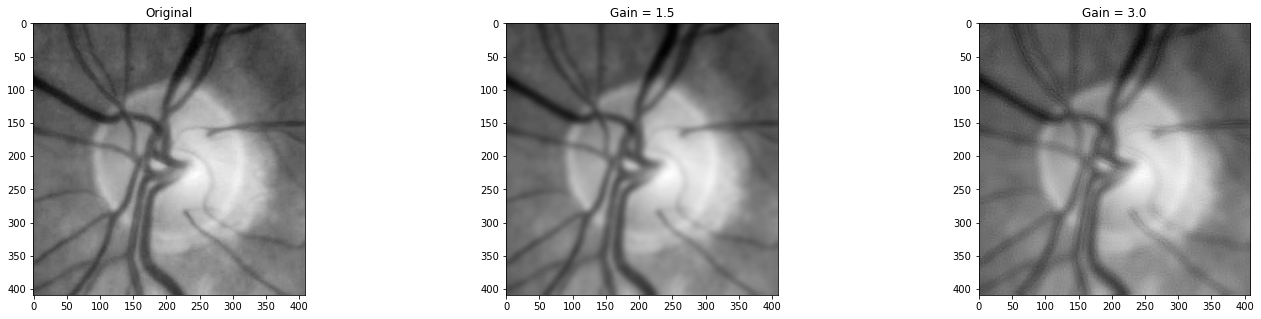

In [ ]:
apply_unsharp_mask('dataset_train_test/train/1/Im429_g_ACRIMA.jpg')

Image dimensions:  torch.Size([409, 409])


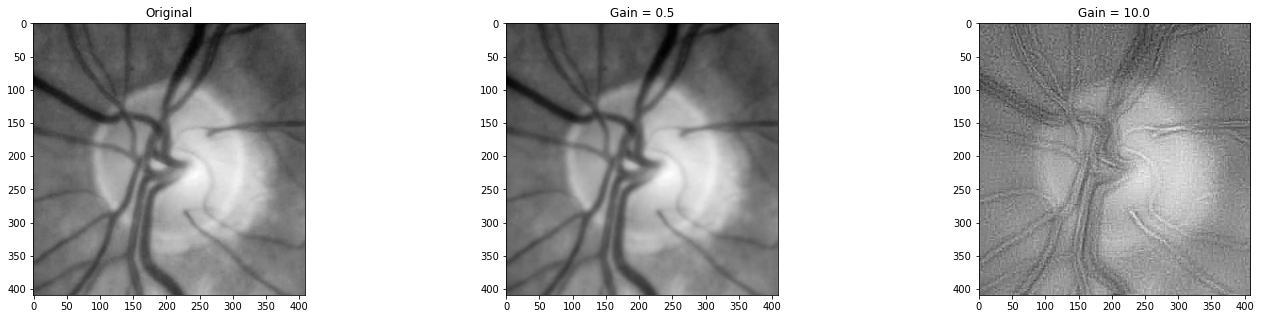

In [ ]:
apply_unsharp_mask('dataset_train_test/train/1/Im429_g_ACRIMA.jpg', [0.5, 10.0])

### 2.(20 puntos) Implemente manualmente (especificando las capas) en py-torch la arquitectura de AlexNet. Entrene la red usando el conjunto de datos de imágenes de fondo de ojo. Calibre los hiper-parámetros necesarios para obtener los mejores resultados posibles y reportelos. Ejecute el  entrenamiento  10  veces  por  15  épocas  por  corrida,  y  reporte  la  tasa de aciertos, falsos positivos y falsos negativos promedio y su desviación estándar para esas 10 corridas.

 * a)  No utilice ningún tipo de aumentado o normalización de datos o transfer learning.

 * b)  Compare  los  resultados  respecto  a  lo  obtenido  con  el  perceptrón multi-capa y coméntelos.



### a) Resultados:

Se implemento la arquitextura AlexNet, con las siguientes consideraciones:

 * Como criterio se utilizó el optimizador $Adam$, en ves del $SGD$, debido al pobre rendimiento obtenido con la última.
 * Como función de perdida se utilizó el cálculo de la entropía cruzada.
 * Como función final de activación en la capa de salida se aplicó la función $LogSoftMax$, esto debido a que se detectó muy bajo rendimiento al utilizar la función $SoftMax$.



**Resultado del entrenamiento**


El entrenamiento de los $10$ modelos consistió en $15$ epochs, dando los siguientes resultados (FP = Falsos positivos, FN = Falsos negativos):


Corrida | Accuracy | FP | FN
--------|----------|----|---
0 | 0.81428 | 31   |  8
1 | 0.90952 | 16   |  3
2 | 0.91428 | 10   |  8
3 | 0.89524 | 20   |  2
4 | 0.88095 | 14   | 11
5 | 0.90476 |  8   | 12
6 | 0.87619 | 16   | 10
7 | 0.89524 | 12   | 10
8 | 0.91428 | 10   |  8
9 | 0.91905 |  8   |  9

Con las siguientes estadísticas:

Accuracies mean=0.8923809523809524 | Std = 0.029369797990684326
FP mean=14.5 | Std = 6.621933252457322
FN mean=8.1 | Std = 3.0805843601498726

Métrica |Promedio | Desv. Estándar
--|--|--
Accuracy |  0.89238 | 0.02937
FP       | 14.5     | 6.62193
FN       |  8.1     | 3.08058


El mejor accuracy alcanzado fue de $0.91905$ (es una mejora marginal con respecto a otros candidatos) en la última corrida del algoritmo:

```
Training AlexNet model #9
Epoch 0 - Training loss: 7.053744614124298
Epoch 1 - Training loss: 0.6770143210887909
Epoch 2 - Training loss: 0.5969741344451904
Epoch 3 - Training loss: 0.3560970276594162
Epoch 4 - Training loss: 0.26860571280121803
Epoch 5 - Training loss: 0.2322692573070526
Epoch 6 - Training loss: 0.2190319523215294
Epoch 7 - Training loss: 0.20516688004136086
Epoch 8 - Training loss: 0.18958478793501854
Epoch 9 - Training loss: 0.16784235835075378
Epoch 10 - Training loss: 0.1719852015376091
Epoch 11 - Training loss: 0.1350920144468546
Epoch 12 - Training loss: 0.11996298469603062
Epoch 13 - Training loss: 0.1737154796719551
Epoch 14 - Training loss: 0.1789659969508648

Training Time (in minutes) = 1.306330184141795
Testing model #9
Number Of Images Tested = 210

Model Accuracy = 0.919047619047619

True positives = 96

True Negatives = 97

False positives = 8

False Negatives = 9
```


### b) Código fuente

#### Estandarización de los datos

torch.Size([128, 3, 227, 227])
torch.Size([128])


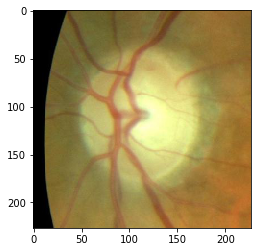

In [ ]:
_IMAGE_SIZE = [227, 227]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(_IMAGE_SIZE),
])

_TRAIN_PATH = 'dataset_train_test/train'
_TEST_PATH = 'dataset_train_test/test'
_BATCH_SIZE = 128


def load_test_train_data(train_path=_TRAIN_PATH, test_path=_TEST_PATH,
                         bach_size=64):
    train_set = datasets.ImageFolder(root=train_path, transform=transform)
    test_set = datasets.ImageFolder(root=test_path, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=bach_size,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bach_size,
                                              shuffle=True)
    return train_loader, test_loader


train_loader, test_loader = load_test_train_data(bach_size=_BATCH_SIZE)
dataiter = iter(train_loader)  # creating a iterator
images, labels = dataiter.next()  # creating images for image and labels for image number (0 to 9)

print(images.shape)
print(labels.shape)

# grayscale
# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# In order to plot a color image with RGB (3) channels, we need to transform the 
# dimensions for imshow from [3 x 128 x 128] to [128 x 128 x 3]:
im2display = images[0].numpy().transpose((1, 2, 0))
plt.imshow(im2display, interpolation='nearest');

#### Definición de la red convolucional AlexNet

In [ ]:
import torch.nn.functional as F


class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.convs = nn.Sequential(
            # layer 1
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),            
            nn.ReLU(),
            # sublayer 1.1
            nn.BatchNorm2d(96),            
            # sublayer 1.2
            nn.MaxPool2d(kernel_size=3, stride=2),            
            
            # layer 2
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),            
            nn.ReLU(),
            # sublayer 2.1
            nn.BatchNorm2d(256),            
            # sublayer 2.2
            nn.MaxPool2d(kernel_size=3, stride=2),            
            
            # layer 3
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        
            # layer 4
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # layer 5
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # sublayer 5.1
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.fcns = nn.Sequential(     
            # layer 6 
            nn.Dropout(0.5),  #, inplace=True),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),

            # layer 7
            nn.Dropout(0.5),  #, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),

            # layer 8
            nn.Linear(4096, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        out = self.convs(x)
        out = out.view(-1, 256 * 6 * 6)
        out = self.fcns(out)
        return out

#### Función de entrenamiento

In [ ]:
def train_model(model, criterion, trainloader, epochs=15, lr=0.01, use_sgd=True):
    time0 = time()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    if not use_sgd:
      optimizer = optim.Adam(params=model.parameters(), lr=lr)
    
    for e in range(epochs):
        running_loss = 0

        #go for every batch
        for images, labels in trainloader:
            #move data to specific device
            images = images.to(device)
            labels = labels.to(device)

            # modeling for each image batch
            output = model(images)

            # calculating the loss
            loss = criterion(output, labels)

            # defining gradient in each epoch as 0
            optimizer.zero_grad()

            # This is where the model learns by backpropagating
            loss.backward()

            # And optimizes its weights here
            optimizer.step()

            # calculating the loss
            running_loss += loss.item()

        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss / len(trainloader)))
    print("\nTraining Time (in minutes) =", (time() - time0) / 60)
    return model


# print("Training CNN model")
# cnn_model = train_model(cnn_model, criterion, train_loader, epochs = 15, lr = 0.01, is_MLP = False)

# print("Training AlexNet model")
# alex_model = train_model(alex_model, criterion, train_loader, epochs=15, lr=0.01, is_MLP=False)


#### Función de validación

In [ ]:
def test_model_cnn(testloader, model):
    tp, tn, fp, fn, correct_count, all_count = 0, 0, 0, 0, 0, 0
    for images, labels in testloader:
        #move data to specific device
        images = images.to(device)
        labels = labels.to(device)
        #get model output
        with torch.no_grad():
            outputs = model(images)
        for i in range(len(labels)):
            #apply exp as the activation function has the log
            output_observation = torch.exp(outputs[i, :])
            #get predicted label
            output_observation_np = list(output_observation.cpu().numpy())
            pred_label = output_observation_np.index(max(output_observation_np))
            #get the label
            true_label = labels.cpu().numpy()[i]
            if (true_label == pred_label):
                correct_count += 1
                if true_label:
                    tp += 1
                else:
                    tn += 1
            elif pred_label == 1: # 1 -> glaucoma
                fp += 1
            else:
                fn += 1

            all_count += 1

    accuracy = correct_count/all_count
    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", accuracy)
    print("\nTrue positives =", tp)
    print("\nTrue Negatives =", tn)
    print("\nFalse positives =", fp)
    print("\nFalse Negatives =", fn)
    return accuracy, all_count, tp, tn, fp, fn

# print("Testing AlexNet model")
# test_model_cnn(test_loader, alex_model)

#### Entrenamiento y validación

In [34]:
def train_models():
    accuracies = []
    fps = []
    fns = []
    tps = []
    tns = []
    best_accuracy = 0.0
    best_model = None
    alpha = 0.001
    criterion = F.cross_entropy
    # criterion = F.nll_loss
    # criterion = nn.NLLLoss() 

    for run in range(10):
        print(f"Training AlexNet model #{run}")

        # seed = torch.initial_seed()
        # print('Used seed : {}'.format(seed))

        new_model = AlexNet()
        new_model.to(device)

        new_model = train_model(new_model, criterion, train_loader, epochs=15,
                                lr=alpha, use_sgd=False)
        print(f"Testing model #{run}")
        accuracy, all_count, tp, tn, fp, fn = test_model_cnn(test_loader, new_model)
        accuracies.append(accuracy)
        fps.append(fp)
        fns.append(fn)
        tps.append(tp)
        tns.append(tn)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = new_model

        torch.cuda.empty_cache()
        print("------------------------------------------------------")

    return best_model, best_accuracy, accuracies, fps, fns, tps, tns


cnn_model, cnn_accuracy, accuracies, fps, fns, tps, tns = train_models()
print(f"Best Model and Accuracy: {cnn_model}\n{cnn_accuracy}")
print('Accuracies: ', accuracies)
print('FPs: ', fps)
print('FNS: ',fns)
print('TPs: ', tps)
print('TNs: ', tns)

Training AlexNet model #0
Epoch 0 - Training loss: 4.409212499856949
Epoch 1 - Training loss: 0.598230168223381
Epoch 2 - Training loss: 0.479624941945076
Epoch 3 - Training loss: 0.36301764845848083
Epoch 4 - Training loss: 0.36433330923318863
Epoch 5 - Training loss: 0.3045016676187515
Epoch 6 - Training loss: 0.27393441274762154
Epoch 7 - Training loss: 0.21142851561307907
Epoch 8 - Training loss: 0.1704795602709055
Epoch 9 - Training loss: 0.16081898659467697
Epoch 10 - Training loss: 0.13780611008405685
Epoch 11 - Training loss: 0.14767183549702168
Epoch 12 - Training loss: 0.1824161298573017
Epoch 13 - Training loss: 0.15477713011205196
Epoch 14 - Training loss: 0.19213931262493134

Training Time (in minutes) = 1.3314168095588683
Testing model #0
Number Of Images Tested = 210

Model Accuracy = 0.8142857142857143

True positives = 97

True Negatives = 74

False positives = 31

False Negatives = 8
------------------------------------------------------
Training AlexNet model #1
Epoc

In [36]:

print(f'Accuracies mean={np.mean(accuracies)} | Std = {np.std(accuracies)}')
print(f'FP mean={np.mean(fps)} | Std = {np.std(fps)}')
print(f'FN mean={np.mean(fns)} | Std = {np.std(fns)}')

Accuracies mean=0.8923809523809524 | Std = 0.029369797990684326
FP mean=14.5 | Std = 6.621933252457322
FN mean=8.1 | Std = 3.0805843601498726


Respaldo de resulado de 10 corridas:

```
Training AlexNet model #0
Epoch 0 - Training loss: 4.409212499856949
Epoch 1 - Training loss: 0.598230168223381
Epoch 2 - Training loss: 0.479624941945076
Epoch 3 - Training loss: 0.36301764845848083
Epoch 4 - Training loss: 0.36433330923318863
Epoch 5 - Training loss: 0.3045016676187515
Epoch 6 - Training loss: 0.27393441274762154
Epoch 7 - Training loss: 0.21142851561307907
Epoch 8 - Training loss: 0.1704795602709055
Epoch 9 - Training loss: 0.16081898659467697
Epoch 10 - Training loss: 0.13780611008405685
Epoch 11 - Training loss: 0.14767183549702168
Epoch 12 - Training loss: 0.1824161298573017
Epoch 13 - Training loss: 0.15477713011205196
Epoch 14 - Training loss: 0.19213931262493134

Training Time (in minutes) = 1.3314168095588683
Testing model #0
Number Of Images Tested = 210

Model Accuracy = 0.8142857142857143

True positives = 97

True Negatives = 74

False positives = 31

False Negatives = 8
------------------------------------------------------
Training AlexNet model #1
Epoch 0 - Training loss: 7.91969621181488
Epoch 1 - Training loss: 0.7633164077997208
Epoch 2 - Training loss: 0.689732700586319
Epoch 3 - Training loss: 0.6650799065828323
Epoch 4 - Training loss: 0.4626731798052788
Epoch 5 - Training loss: 0.35425418242812157
Epoch 6 - Training loss: 0.31563709676265717
Epoch 7 - Training loss: 0.26410380750894547
Epoch 8 - Training loss: 0.23464170098304749
Epoch 9 - Training loss: 0.25425848737359047
Epoch 10 - Training loss: 0.2007666975259781
Epoch 11 - Training loss: 0.18081297725439072
Epoch 12 - Training loss: 0.16868583858013153
Epoch 13 - Training loss: 0.1579000186175108
Epoch 14 - Training loss: 0.11532524041831493

Training Time (in minutes) = 1.3597134709358216
Testing model #1
Number Of Images Tested = 210

Model Accuracy = 0.9095238095238095

True positives = 102

True Negatives = 89

False positives = 16

False Negatives = 3
------------------------------------------------------
Training AlexNet model #2
Epoch 0 - Training loss: 4.86513078212738
Epoch 1 - Training loss: 0.7124519050121307
Epoch 2 - Training loss: 0.4978316128253937
Epoch 3 - Training loss: 0.3252159208059311
Epoch 4 - Training loss: 0.25599656254053116
Epoch 5 - Training loss: 0.21301956847310066
Epoch 6 - Training loss: 0.19231393933296204
Epoch 7 - Training loss: 0.17949404008686543
Epoch 8 - Training loss: 0.15781814977526665
Epoch 9 - Training loss: 0.14773819595575333
Epoch 10 - Training loss: 0.15778442658483982
Epoch 11 - Training loss: 0.14815355278551579
Epoch 12 - Training loss: 0.12651965208351612
Epoch 13 - Training loss: 0.12321885116398335
Epoch 14 - Training loss: 0.11048233509063721

Training Time (in minutes) = 1.323491128285726
Testing model #2
Number Of Images Tested = 210

Model Accuracy = 0.9142857142857143

True positives = 97

True Negatives = 95

False positives = 10

False Negatives = 8
------------------------------------------------------
Training AlexNet model #3
Epoch 0 - Training loss: 2.9686502814292908
Epoch 1 - Training loss: 0.6192364990711212
Epoch 2 - Training loss: 0.5517578199505806
Epoch 3 - Training loss: 0.3935011178255081
Epoch 4 - Training loss: 0.2969389893114567
Epoch 5 - Training loss: 0.23967846855521202
Epoch 6 - Training loss: 0.19333287701010704
Epoch 7 - Training loss: 0.20125416666269302
Epoch 8 - Training loss: 0.1568476054817438
Epoch 9 - Training loss: 0.1514927726238966
Epoch 10 - Training loss: 0.14027129486203194
Epoch 11 - Training loss: 0.14051164872944355
Epoch 12 - Training loss: 0.15108233876526356
Epoch 13 - Training loss: 0.14215190336108208
Epoch 14 - Training loss: 0.13052034936845303

Training Time (in minutes) = 1.3303024291992187
Testing model #3
Number Of Images Tested = 210

Model Accuracy = 0.8952380952380953

True positives = 103

True Negatives = 85

False positives = 20

False Negatives = 2
------------------------------------------------------
Training AlexNet model #4
Epoch 0 - Training loss: 5.2334970980882645
Epoch 1 - Training loss: 0.6769487708806992
Epoch 2 - Training loss: 0.47973988950252533
Epoch 3 - Training loss: 0.34579261764883995
Epoch 4 - Training loss: 0.2979614958167076
Epoch 5 - Training loss: 0.2421189844608307
Epoch 6 - Training loss: 0.2293112650513649
Epoch 7 - Training loss: 0.20128001645207405
Epoch 8 - Training loss: 0.2061457596719265
Epoch 9 - Training loss: 0.20843204483389854
Epoch 10 - Training loss: 0.18794141709804535
Epoch 11 - Training loss: 0.18730889447033405
Epoch 12 - Training loss: 0.20123767480254173
Epoch 13 - Training loss: 0.17014120146632195
Epoch 14 - Training loss: 0.16069870814681053

Training Time (in minutes) = 1.3279921650886535
Testing model #4
Number Of Images Tested = 210

Model Accuracy = 0.8809523809523809

True positives = 94

True Negatives = 91

False positives = 14

False Negatives = 11
------------------------------------------------------
Training AlexNet model #5
Epoch 0 - Training loss: 9.24378377199173
Epoch 1 - Training loss: 0.7643589824438095
Epoch 2 - Training loss: 0.5255799442529678
Epoch 3 - Training loss: 0.3930262327194214
Epoch 4 - Training loss: 0.3215753883123398
Epoch 5 - Training loss: 0.266399297863245
Epoch 6 - Training loss: 0.2407839633524418
Epoch 7 - Training loss: 0.1999569684267044
Epoch 8 - Training loss: 0.22413212060928345
Epoch 9 - Training loss: 0.20516785606741905
Epoch 10 - Training loss: 0.1841609925031662
Epoch 11 - Training loss: 0.23940599150955677
Epoch 12 - Training loss: 0.17841477319598198
Epoch 13 - Training loss: 0.18850943818688393
Epoch 14 - Training loss: 0.14414063282310963

Training Time (in minutes) = 1.3086912512779236
Testing model #5
Number Of Images Tested = 210

Model Accuracy = 0.9047619047619048

True positives = 93

True Negatives = 97

False positives = 8

False Negatives = 12
------------------------------------------------------
Training AlexNet model #6
Epoch 0 - Training loss: 4.004626169800758
Epoch 1 - Training loss: 0.7693904489278793
Epoch 2 - Training loss: 0.5795592218637466
Epoch 3 - Training loss: 0.4153172895312309
Epoch 4 - Training loss: 0.34367653727531433
Epoch 5 - Training loss: 0.36328640580177307
Epoch 6 - Training loss: 0.29094545543193817
Epoch 7 - Training loss: 0.2767517603933811
Epoch 8 - Training loss: 0.2776155471801758
Epoch 9 - Training loss: 0.2356252372264862
Epoch 10 - Training loss: 0.2155757062137127
Epoch 11 - Training loss: 0.17662978172302246
Epoch 12 - Training loss: 0.16971357725560665
Epoch 13 - Training loss: 0.14819402433931828
Epoch 14 - Training loss: 0.16946518421173096

Training Time (in minutes) = 1.3264220356941223
Testing model #6
Number Of Images Tested = 210

Model Accuracy = 0.8761904761904762

True positives = 95

True Negatives = 89

False positives = 16

False Negatives = 10
------------------------------------------------------
Training AlexNet model #7
Epoch 0 - Training loss: 5.460719212889671
Epoch 1 - Training loss: 0.6600822508335114
Epoch 2 - Training loss: 0.38895319402217865
Epoch 3 - Training loss: 0.2959512174129486
Epoch 4 - Training loss: 0.32814837619662285
Epoch 5 - Training loss: 0.22375090047717094
Epoch 6 - Training loss: 0.2549467124044895
Epoch 7 - Training loss: 0.19223397225141525
Epoch 8 - Training loss: 0.15986689552664757
Epoch 9 - Training loss: 0.1757549699395895
Epoch 10 - Training loss: 0.18464967980980873
Epoch 11 - Training loss: 0.17739851772785187
Epoch 12 - Training loss: 0.2457060031592846
Epoch 13 - Training loss: 0.24164820462465286
Epoch 14 - Training loss: 0.19814205169677734

Training Time (in minutes) = 1.304660181204478
Testing model #7
Number Of Images Tested = 210

Model Accuracy = 0.8952380952380953

True positives = 95

True Negatives = 93

False positives = 12

False Negatives = 10
------------------------------------------------------
Training AlexNet model #8
Epoch 0 - Training loss: 4.334635034203529
Epoch 1 - Training loss: 0.6928967237472534
Epoch 2 - Training loss: 0.49032213538885117
Epoch 3 - Training loss: 0.2755943052470684
Epoch 4 - Training loss: 0.2166319079697132
Epoch 5 - Training loss: 0.2581549249589443
Epoch 6 - Training loss: 0.24148786440491676
Epoch 7 - Training loss: 0.24551604688167572
Epoch 8 - Training loss: 0.2668638192117214
Epoch 9 - Training loss: 0.22943878173828125
Epoch 10 - Training loss: 0.20874151214957237
Epoch 11 - Training loss: 0.19501730054616928
Epoch 12 - Training loss: 0.16537673026323318
Epoch 13 - Training loss: 0.16558202728629112
Epoch 14 - Training loss: 0.25494855269789696

Training Time (in minutes) = 1.321120031674703
Testing model #8
Number Of Images Tested = 210

Model Accuracy = 0.9142857142857143

True positives = 97

True Negatives = 95

False positives = 10

False Negatives = 8
------------------------------------------------------
Training AlexNet model #9
Epoch 0 - Training loss: 7.053744614124298
Epoch 1 - Training loss: 0.6770143210887909
Epoch 2 - Training loss: 0.5969741344451904
Epoch 3 - Training loss: 0.3560970276594162
Epoch 4 - Training loss: 0.26860571280121803
Epoch 5 - Training loss: 0.2322692573070526
Epoch 6 - Training loss: 0.2190319523215294
Epoch 7 - Training loss: 0.20516688004136086
Epoch 8 - Training loss: 0.18958478793501854
Epoch 9 - Training loss: 0.16784235835075378
Epoch 10 - Training loss: 0.1719852015376091
Epoch 11 - Training loss: 0.1350920144468546
Epoch 12 - Training loss: 0.11996298469603062
Epoch 13 - Training loss: 0.1737154796719551
Epoch 14 - Training loss: 0.1789659969508648

Training Time (in minutes) = 1.306330184141795
Testing model #9
Number Of Images Tested = 210

Model Accuracy = 0.919047619047619

True positives = 96

True Negatives = 97

False positives = 8

False Negatives = 9
------------------------------------------------------
Best Model and Accuracy: AlexNet(
  (convs): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcns): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=2, bias=True)
    (7): LogSoftmax(dim=1)
  )
)
0.919047619047619
Accuracies:  [0.8142857142857143, 0.9095238095238095, 0.9142857142857143, 0.8952380952380953, 0.8809523809523809, 0.9047619047619048, 0.8761904761904762, 0.8952380952380953, 0.9142857142857143, 0.919047619047619]
FPs:  [31, 16, 10, 20, 14, 8, 16, 12, 10, 8]
FNS:  [8, 3, 8, 2, 11, 12, 10, 10, 8, 9]
TPs:  [97, 102, 97, 103, 94, 93, 95, 95, 97, 96]
TNs:  [74, 89, 95, 85, 91, 97, 89, 93, 95, 97]
```